In [514]:
# Librerias a utilizar
from sklearn import datasets  # data a utilizar
import matplotlib.pyplot as plt  # graficar
from sklearn.neighbors import KNeighborsClassifier  # KNN para comparar
import numpy as np  # segmentar la data
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)  # Mostrar reporte de resultados
import random # para ordenar la data de forma aleatoria

# Leer, filtrar y visualizar los datos

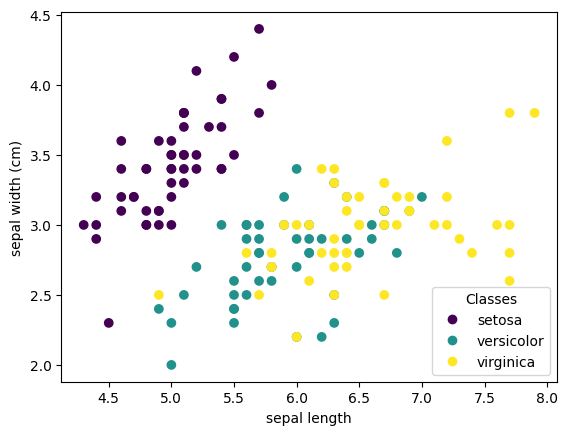

In [515]:
iris = datasets.load_iris() #cargar iris
#species_data_count = sum(1 for i in iris.target if i < 2) #contar los datos que nos interesan (por especie)
#data = iris.data[:species_data_count] #filtrar por especie
data = iris.data
#Features
sepal_length = data[:, 0]
sepal_width = data[:, 1]
#Graficar
_, ax = plt.subplots()
#scatter = ax.scatter(sepal_length, sepal_width, c=iris.target[:species_data_count])
scatter = ax.scatter(sepal_length, sepal_width, c=iris.target)
ax.set(xlabel="sepal length", ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [516]:
class Sample: #clase para guardar los datos de las muestras
    def __init__(self, sepal_length, sepal_width, type):
        self.sepal_length = sepal_length
        self.sepal_width = sepal_width
        self.type = "setosa" if type == 0 else ("versicolor" if type == 1 else "virginica")

    def __str__(self):
        return f"Sample: {self.sepal_length} {self.sepal_width} {self.type}"
    
#Ajustar los datos para que su manipulación sea más legible
data = []
for i in range(min(len(sepal_length), len(sepal_width), len(iris.target))):
    data.append(Sample(sepal_length[i], sepal_width[i], iris.target[i]))

#reordenar aleatoriamente la data
random.shuffle(data)
#segmentar la data (50% train, 20% validation, 30% test)
train, validation, test = np.split(
    data, [int(0.50 * len(data)), int(0.80 * len(data))]
)

# Implementación propia de KNN

In [517]:
def KNN(_k, data: list[Sample]):  # retorna una funcion para predecir dado k y los datos
    def predict(x, y):
        if len(x) != len(y):
            raise Exception("x and y must have the same length")
        predictions = []
        for i in range(len(x)):  # por cada punto a predecir
            # Calcular la distancia del punto a todos los puntos de la data con la que el algoritmo está entrenado
            distances = []
            for j in range(len(data)):
                distances.append(
                    [
                        (
                            (data[j].sepal_length - x[i]) ** 2
                            + (data[j].sepal_width - y[i]) ** 2
                        )
                        ** 0.5,
                        data[j].type,
                    ]
                )
            # Ordenar las distancias encontradas de menor a mayor
            distances = sorted(distances, key=lambda x: x[0])
            k = _k
            while k > 0:
                # Filtrar las k primeras
                distances = distances[:k]
                # Calcular frecuencia de cada categoría
                setosa_count = sum(
                    list(map(lambda x: 1 if x[1] == "setosa" else 0, distances))
                )
                versicolor_count = sum(
                    list(map(lambda x: 1 if x[1] == "versicolor" else 0, distances))
                )
                virginica_count = sum(
                    list(map(lambda x: 1 if x[1] == "virginica" else 0, distances))
                )
                max_count = max([setosa_count, versicolor_count, virginica_count])
                # si hay un empate en máxima frecuencia, se disminuye k y se vuelve a contar
                if max_count == setosa_count:
                    if (
                        setosa_count == versicolor_count
                        or setosa_count == virginica_count
                    ):
                        k -= 1
                    else:
                        predictions.append("setosa")
                        break
                elif max_count == versicolor_count:
                    if versicolor_count == virginica_count:
                        k -= 1
                    else:
                        predictions.append("versicolor")
                        break
                else:
                    predictions.append("virginica")
                    break
        return predictions
    return predict

# Optimizar k

In [518]:
def find_optimal_k(
    data, algorithm, initial_value, graph=True, graph_title="Error", max_value = 10
):
    k = initial_value
    accuracy = 0
    graph_data = []
    X = list(map(lambda x: x.sepal_length, data))
    Y = list(map(lambda x: x.sepal_width, data))
    for i in range(initial_value, max_value):
        predict = algorithm(i, data)
        # Predecir los datos de validación
        predictions = predict(X, Y)
        # Calcular reporte de resultados
        report = classification_report(
            list(map(lambda x: x.type, data)), predictions, output_dict=True
        )
        graph_data.append([i, 1 - report["accuracy"]])
        # Si se obtiene una precisión de 1.0, se usa ese valor de k
        if report["accuracy"] == 1.0:
            k = i
            break
        # Si no, se usa el k con mayor precisión
        elif report["accuracy"] > accuracy:
            k = i
            accuracy = report["accuracy"]
    #graficar error
    if graph:
        plt.plot(
            list(map(lambda x: x[0], graph_data)),
            list(map(lambda x: x[1], graph_data)),
            len(graph_data) == 1 and "ro" or "r-",
            scalex=1,
        )
        plt.title(graph_title + " - k seleccionada: " + str(k))
        plt.xlabel("k")
        plt.ylabel("error %")
        plt.show()
    return k

# Prueba de implementación propia de KNN

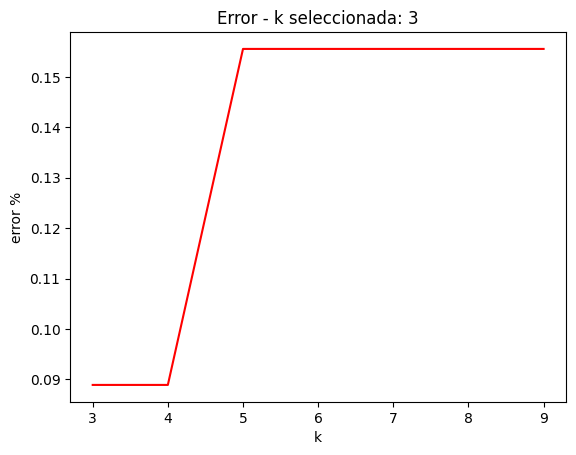

In [519]:
# Calcular la k óptima para nuestro modelo usando data de validacion
own_k = find_optimal_k(validation, KNN, 3)
#Inicializar nuestro modelo
knn_predict = KNN(own_k, train)
X = list(map(lambda x: x.sepal_length, test))
Y = list(map(lambda x: x.sepal_width, test))
true_classes = list(map(lambda x: x.type, test))
# Predecir los datos de test
predictions = knn_predict(X, Y)
# Calcular matriz de confusión
own_report = classification_report(true_classes, predictions)
own_matrix = confusion_matrix(true_classes, predictions)

# Prueba del KNN de sklearn

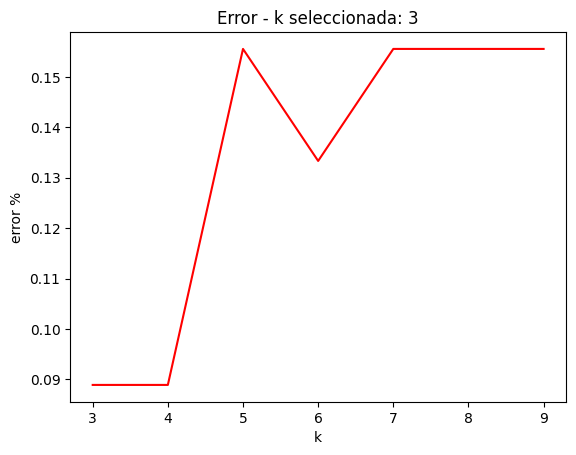

In [520]:
# Adaptar el KNN de sklearn para que sea compatible con el algoritmo de búsqueda de k óptimo
def KNN_adapter(k, data: list[Sample]):
    knn = KNeighborsClassifier(n_neighbors=k)
    x = list(map(lambda x: [x.sepal_length, x.sepal_width], data))
    y = list(map(lambda x: x.type, data))
    knn.fit(x, y)

    def predict(x,y):
        if len(x) != len(y):
            raise Exception("x and y must have the same length")
        samples = []
        for i in range(len(x)):
            samples.append([x[i], y[i]])
        return knn.predict(samples)

    return predict

# Calcular la k óptima para el modelo de sklearn usando data de validacion
sklearn_k = find_optimal_k(validation, KNN_adapter, 3, len(test))
# Inicializar el modelo de KNN de sklearn
knn_model = KNeighborsClassifier(n_neighbors=sklearn_k)
# Entrenar el modelo
x = list(map(lambda x: [x.sepal_length, x.sepal_width], train))
y = list(map(lambda x: x.type, train))
knn_model.fit(x, y)

# Predecir los datos de test
y_pred = knn_model.predict(list(map(lambda x: [x.sepal_length, x.sepal_width], test)))

# Calcular matriz de confusión
sklearn_report = classification_report(true_classes, y_pred)
sklearn_matrix = confusion_matrix(true_classes, y_pred)

# Comparación de resultados

precision
Precision can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

recall
Recall is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

f1 score
The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

support
Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

Reporte de resultados de implementación propia - K óptima = 3
              precision    recall  f1-score   support

      setosa       1.00      0.86      0.92         7
  versicolor       0.50      0.64      0.56        11
   virginica       0.60      0.50      0.55        12

    accuracy                           0.63        30
   macro avg       0.70      0.66      0.68        30
weighted avg       0.66      0.63      0.64        30

Reporte de resultados de implementación de sklearn - K óptima = 3
              precision    recall  f1-score   support

      setosa       1.00      0.86      0.92         7
  versicolor       0.40      0.55      0.46        11
   virginica       0.44      0.33      0.38        12

    accuracy                           0.53        30
   macro avg       0.61      0.58      0.59        30
weighted avg       0.56      0.53      0.54        30



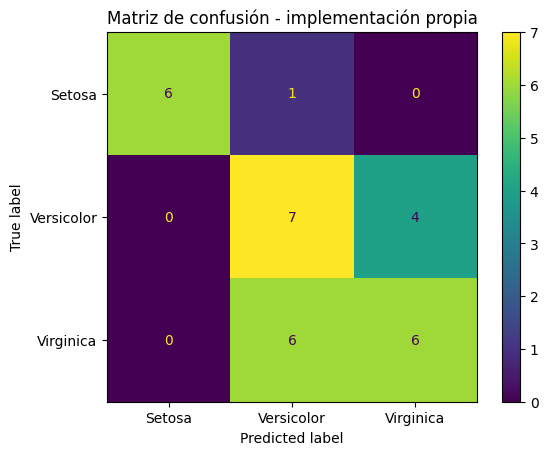

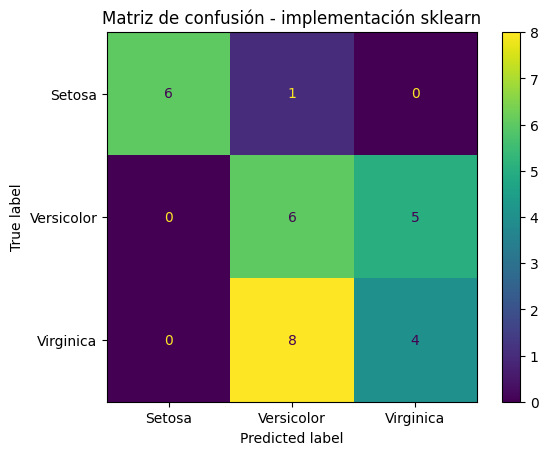

In [521]:
print("Reporte de resultados de implementación propia - K óptima = " + str(own_k))
print(own_report)
print(
    "Reporte de resultados de implementación de sklearn - K óptima = " + str(sklearn_k)
)
print(sklearn_report)

ownMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=own_matrix, display_labels=["Setosa", "Versicolor", "Virginica"],
)
ownMatrixDisplay.plot()
plt.title("Matriz de confusión - implementación propia")
plt.show()
sklearnMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=sklearn_matrix, display_labels=["Setosa", "Versicolor", "Virginica"]
)
sklearnMatrixDisplay.plot()
plt.title("Matriz de confusión - implementación sklearn")
plt.show()

# Conclusiones:
Se observan resultados similares entre la implementación propia y la de sklearn.
En ambos casos, se obtienen mejores resultados en la predicción de nuevas muestras de la clase setosa, y una pérdida de precisión en las otras 2 clases. Esto se da debido a que los puntos que representan las muestras de setosa están separados de los demás, mientras que los puntos pertenecientes a las otras 2 clases están mezclados en una misma zona del plano.